# 4.3 - Train a model for each dataset category, comparing it to random data

In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset, one_hot
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness-copy'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rawtset, rawvset = rawset.rnd_split_fraction_by_category(0.5)

In [4]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [5]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.blksampler.dataset.categories[self.cat])


In [6]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))

        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks, use_multiprocessing=False, workers=0)
            predict = predict[:,0]-predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.cat)


In [7]:
steps_per_epoch=28
patience=10

In [8]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=steps_per_epoch,
                 steps_per_epoch=steps_per_epoch,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=patience):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None, previous_model2=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        if previous_model2:
            tsampler = CatSampler(previous_model2, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        if previous_model2:
            vsampler = CatSampler(previous_model2, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [9]:
def rndgen(block_instance=False):
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        if block_instance:
            yield (rdata, np.array([0,1]*100).reshape(100,2))
        else:
            yield rdata

# Train pass1 models

In [10]:
r = Reporter2(result_dir + "/pass1.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CLD(2, 256)
    print(cat)
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    
    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
xml
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
val_acc = 0.99785715 struct_acc= 0.991 rnd_acc= 1.0
csv
val_acc = 0.9992857 struct_acc= 0.998 rnd_acc= 1.0
ps
val_acc = 0.995 struct_acc= 0.99 rnd_acc= 1.0
doc
val_acc = 0.9257143 struct_acc= 0.874 rnd_acc= 0.992
pdf
val_acc = 0.81392854 struct_acc= 0.704 rnd_acc= 0.941
ppt
val_acc = 0.8832143 struct_acc= 0.824 rnd_acc= 0.95
log
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
txt
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
png
val_acc = 0.80714285 struct_acc= 0.683 rnd_acc= 0.936
dwf
val_acc = 0.7182143 struct_acc= 0.46 rnd_acc= 0.958
wp
val_acc = 0.9982143 struct_acc= 1.0 rnd_acc= 1.0
gif
val_acc = 0.92285717 struct_acc= 0.862 rnd_acc= 0.992
swf
val_acc = 0.7782143 struct_acc= 0.652 rnd_acc= 0.911
hlp
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
eps
val_acc = 1.0 struct_acc= 1.0 r

# Load data

In [11]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data['struct_TP'] = data['struct_acc'] - ((1 - data['struct_acc'])*(1 - data['rnd_acc'])/data['rnd_acc'])
data['struct_precision'] = data['struct_TP']/data['struct_acc']
data = data.sort_values('struct_TP')
data

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struct_TP,struct_precision
9,dwf,0.718214,0.460,0.958,14m25s,37,0.436326,0.948534
20,gz,0.770714,0.576,0.931,15m21s,39,0.544576,0.945444
19,kmz,0.782857,0.638,0.927,15m04s,38,0.609493,0.955318
12,swf,0.778214,0.652,0.911,13m47s,35,0.618002,0.947856
8,png,0.807143,0.683,0.936,20m58s,54,0.661325,0.968265
4,pdf,0.813929,0.704,0.941,18m05s,47,0.685441,0.973638
23,pptx,0.842857,0.764,0.949,14m58s,38,0.751317,0.983399
24,pps,0.864286,0.815,0.921,15m59s,40,0.799131,0.980529
5,ppt,0.883214,0.824,0.950,24m35s,64,0.814737,0.988758
11,gif,0.922857,0.862,0.992,15m24s,40,0.860887,0.998709


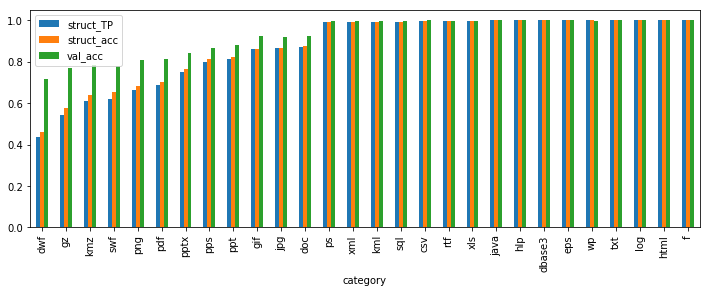

In [12]:
data.plot.bar('category', ['struct_TP', 'struct_acc', 'val_acc'], figsize=(12,4))
plt.show()

In [13]:
data.mean()

val_acc              0.928814
struct_acc           0.881500
rnd_acc              0.978214
Epochs              24.607143
struct_TP            0.874349
struct_precision     0.988803
dtype: float64

In [14]:
1-np.sum(data['struct_TP'])/28

0.12565068298402282

In [15]:
1-(np.sum(data['struct_TP'])+(1-0.22))/28

0.09779354012688002

# Use models to evaluate dataset

In [16]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
f 1.0 1.0 1.0
pdf 0.729 0.924 0.7067099346490564
pps 0.829 0.925 0.8151351333935823
wp 0.996 1.0 0.9959999918937683
doc 0.875 0.993 0.874118828135434
kml 0.99 1.0 0.9900000095367432
log 1.0 1.0 1.0
xls 0.997 1.0 0.996999979019165
html 1.0 1.0 1.0
gz 0.604 0.936 0.5769230426337509
ps 0.99 0.999 0.9899899996652832
java 1.0 1.0 1.0
png 0.679 0.934 0.6563169435453404
kmz 0.647 0.945 0.6264550392700001
rtf 0.994 1.0 0.9940000176429749
sql 0.992 1.0 0.9919999837875366
ppt 0.844 0.948 0.835443021261316
csv 0.999 1.0 0.9990000128746033
eps 1.0 1.0 1.0
pptx 0.776 0.949 0.7639620896873413
dbase3 1.0 1.0 1.0
dwf 0.487 0.949 0.4594309684630506
gif 0.

# Load evaluation data

In [17]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
21,dwf,0.487,0.949,0.459431
9,gz,0.604,0.936,0.576923
25,swf,0.641,0.904,0.602876
13,kmz,0.647,0.945,0.626455
12,png,0.679,0.934,0.656317
1,pdf,0.729,0.924,0.706710
19,pptx,0.776,0.949,0.763962
2,pps,0.829,0.925,0.815135
16,ppt,0.844,0.948,0.835443
27,jpg,0.841,0.989,0.839232


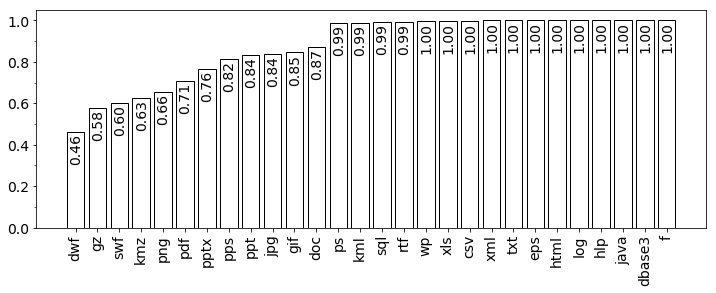

In [18]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [19]:
data3.mean()

struct_acc    0.884214
rnd_acc       0.977786
struct_TP     0.877142
dtype: float64

In [20]:
1-np.sum(data3['struct_TP'])/28

0.1228584308887678

In [21]:
1-(np.sum(data3['struct_TP'])+(1-0.27))/28

0.09678700231733917

# Train pass2 models

In [22]:
if os.path.exists(result_dir + "/pass2.tsv"):
    os.remove(result_dir + "/pass2.tsv")
r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
threshold=0.5
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    model = CLD(2, 256)
    print(cat)
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10,use_multiprocessing=False,workers=0)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

doc
val_acc = 0.99714285 struct_acc= 0.992 rnd_acc= 0.998
pdf
val_acc = 0.95535713 struct_acc= 0.935 rnd_acc= 0.983
ppt
val_acc = 0.9714286 struct_acc= 0.966 rnd_acc= 0.99
png
val_acc = 0.94714284 struct_acc= 0.909 rnd_acc= 0.97
dwf
val_acc = 0.92035717 struct_acc= 0.903 rnd_acc= 0.958
gif
val_acc = 0.9667857 struct_acc= 0.957 rnd_acc= 0.983
swf
val_acc = 0.95714283 struct_acc= 0.952 rnd_acc= 0.971
jpg
val_acc = 0.9717857 struct_acc= 0.983 rnd_acc= 0.968
kmz
val_acc = 0.9475 struct_acc= 0.935 rnd_acc= 0.963
gz
val_acc = 0.94607145 struct_acc= 0.949 rnd_acc= 0.948
pptx
val_acc = 0.96107143 struct_acc= 0.929 rnd_acc= 0.98
pps
val_acc = 0.9753571 struct_acc= 0.982 rnd_acc= 0.97


# Load pass2 data

In [23]:
data2 = pd.read_csv(result_dir + "/pass2.tsv", sep='\t')
data2['struc_precision'] = data2['struct_acc'] - ((1 - data2['struct_acc'])*(1 - data2['rnd_acc'])/data2['rnd_acc'])
data2 = data2.sort_values('struc_precision')
data2

,category,val_acc,struct_acc,rnd_acc,Time,Epochs,struc_precision
4,dwf,0.920357,0.903,0.958,22m07s,29,0.898747
3,png,0.947143,0.909,0.970,41m15s,65,0.906186
10,pptx,0.961071,0.929,0.980,36m53s,53,0.927551
8,kmz,0.947500,0.935,0.963,24m32s,36,0.932503
1,pdf,0.955357,0.935,0.983,34m50s,54,0.933876
9,gz,0.946071,0.949,0.948,24m10s,33,0.946203
6,swf,0.957143,0.952,0.971,35m53s,48,0.950566
5,gif,0.966786,0.957,0.983,25m13s,40,0.956256
2,ppt,0.971429,0.966,0.990,36m23s,59,0.965657
11,pps,0.975357,0.982,0.970,38m32s,57,0.981443


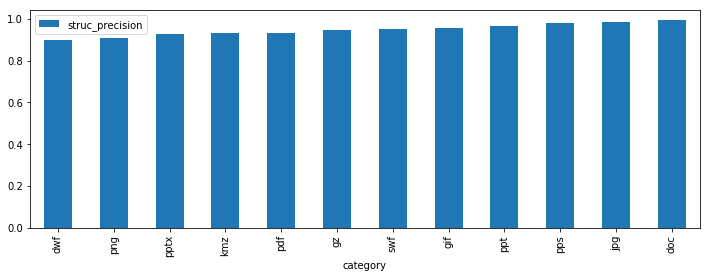

In [24]:
data2.plot.bar('category', ['struc_precision'], figsize=(12,4))
plt.show()

# Use models to evaluate dataset

In [25]:
if os.path.exists(result_dir + "/evaluate.tsv"):
    os.remove(result_dir + "/evaluate.tsv")
r = Reporter2(result_dir + "/evaluate.tsv")
for cat, vset in by_categoryV.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    struct_TP = struct_acc - (1-struct_acc)*(1-rnd_acc)/rnd_acc
    
    print(cat, struct_acc, rnd_acc, struct_TP )
    r.line(cat=cat, struct_acc=struct_acc, rnd_acc=rnd_acc, struct_TP=struct_TP)
r.close()

f 1.0 1.0 1.0
pdf 0.725 0.942 0.7080679571431202
pps 0.829 0.927 0.8155339737157016
wp 0.997 1.0 0.996999979019165
doc 0.881 0.988 0.8795546350485335
kml 0.991 1.0 0.9909999966621399
log 1.0 1.0 1.0
xls 0.994 1.0 0.9940000176429749
html 1.0 1.0 1.0
gz 0.598 0.95 0.5768420894126151
ps 0.99 1.0 0.9900000095367432
java 1.0 1.0 1.0
png 0.687 0.929 0.6630785612298805
kmz 0.654 0.933 0.6291532633414261
rtf 0.994 1.0 0.9940000176429749
sql 0.995 1.0 0.9950000047683716
ppt 0.83 0.934 0.8179871371391814
csv 0.999 1.0 0.9990000128746033
eps 1.0 1.0 1.0
pptx 0.786 0.935 0.7711230095156425
dbase3 1.0 1.0 1.0
dwf 0.454 0.954 0.42767294968768166
gif 0.86 0.985 0.8578680368917043
txt 1.0 1.0 1.0
xml 0.996 1.0 0.9959999918937683
swf 0.637 0.899 0.5962180421471808
hlp 1.0 1.0 1.0
jpg 0.852 0.982 0.8492871660759008


# Load evaluation data

In [26]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('struct_TP')
data3

,cat,struct_acc,rnd_acc,struct_TP
21,dwf,0.454,0.954,0.427673
9,gz,0.598,0.950,0.576842
25,swf,0.637,0.899,0.596218
13,kmz,0.654,0.933,0.629153
12,png,0.687,0.929,0.663079
1,pdf,0.725,0.942,0.708068
19,pptx,0.786,0.935,0.771123
2,pps,0.829,0.927,0.815534
16,ppt,0.830,0.934,0.817987
27,jpg,0.852,0.982,0.849287


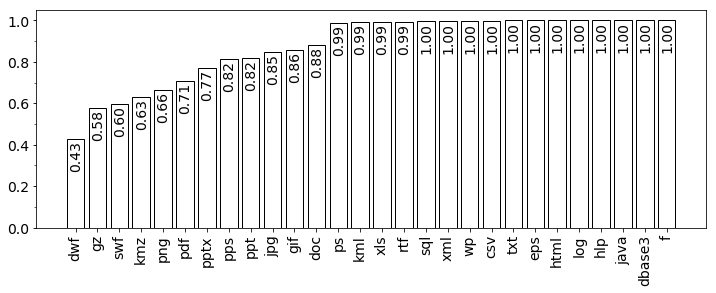

In [27]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [28]:
data3.mean()

struct_acc    0.883893
rnd_acc       0.977071
struct_TP     0.876728
dtype: float64

In [29]:
1-np.sum(data3['struct_TP'])/28

0.12327189816466755

In [30]:
1-(np.sum(data3['struct_TP'])+(1-0.27))/28

0.09720046959323891

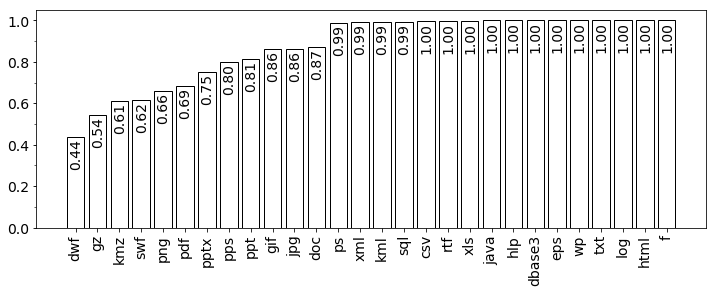

In [31]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data['category'], data['struct_TP'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawvset.ix_to_cat[i]
    v = data.iloc[i,6]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)

# Roc pass1

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
by_category = rawset.by_category()
cat = 'jpg'
dataset = by_category[cat]
dataset.rebuild_categories(categories=['jpg', 'zzz'])

model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

In [34]:
tsampler = BlockSamplerByFile(dataset)
tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat='jpg')

tbenc = BatchEncoder(tsampler,
                     batch_size=1000,
                     xs_encoder='one_hot')
xs, ys = next(iter(tbenc))

In [35]:
datalen = len(xs)
predict = model.predict(xs, batch_size=100)
# predict = np.argmax(predict, axis=-1)

In [36]:
score = predict[:,0]-predict[:,1]
mask = score > 0.9
print(len(score[mask]), len(score))
fpr, tpr, thresholds = roc_curve(ys[:,0][mask], score[mask])
mask = thresholds > 0
fpr[mask], tpr[mask], thresholds[mask]

397 1000


(array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0.5, 0.5, 1. ,
        1. ]),
 array([0.        , 0.00253165, 0.05316456, 0.05822785, 0.07341772,
        0.07848101, 0.18734177, 0.19493671, 0.23797468, 0.24303797,
        0.27341772, 0.27848101, 0.43037975, 0.43544304, 0.52911392,
        0.53924051, 0.54683544, 0.55443038, 0.66329114, 0.66835443,
        0.71139241, 0.71139241, 0.78227848, 0.78734177, 0.86835443,
        0.86835443, 1.        ]),
 array([1.9999826 , 0.99998266, 0.99993473, 0.9999339 , 0.99990946,
        0.9999089 , 0.99981016, 0.9998057 , 0.99974114, 0.99974036,
        0.99969155, 0.9996906 , 0.9992459 , 0.99924   , 0.9986645 ,
        0.9985907 , 0.9985491 , 0.998542  , 0.99710023, 0.9970979 ,
        0.9961318 , 0.99602914, 0.9902664 , 0.99011964, 0.97865415,
        0.97844946, 0.9094641 ], dtype=float32))

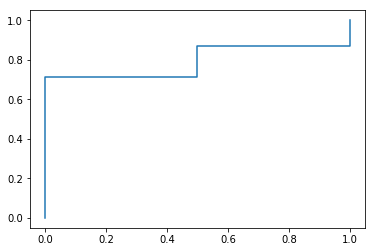

In [37]:
plt.plot(fpr, tpr)

(array([479.,  15.,  16.,  12.,   8.,   8.,   8.,  13.,  21., 420.]),
 array([-9.9995595e-01, -7.9996210e-01, -5.9996825e-01, -3.9997438e-01,
        -1.9998051e-01,  1.3351440e-05,  2.0000722e-01,  4.0000108e-01,
         5.9999496e-01,  7.9998881e-01,  9.9998266e-01], dtype=float32),
 <a list of 10 Patch objects>)

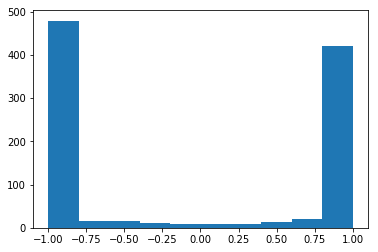

In [38]:
plt.hist(predict[:,0]-predict[:,1])

# Use models to evaluate dataset - using pass2

In [39]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [40]:
if os.path.exists(result_dir + "/evaluate2.tsv"):
    os.remove(result_dir + "/evaluate2.tsv")
r = Reporter2(result_dir + "/evaluate2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model1 = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model1.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)

    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        model2 = tf.keras.models.load_model(result_dir + '/%s_pass2.h5' % cat)
        xs = xs[predict==0]
        datalen = len(xs)
        predict = model2.predict(xs, batch_size=100)
        predict = np.argmax(predict, axis=-1)

    not_random = len(predict[predict==0])/datalen
    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        predict = model2.predict_generator(rndgen(), steps=10)
    else:
        predict = model1.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/(10*100)
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

csv 0.999 1.0 0.999
doc 0.987750556792873 1.0 0.987750556792873
pps 0.9172749391727494 0.963 0.9140965100443919
pdf 0.9051948051948052 0.984 0.9036532573117939
f 1.0 1.0 1.0
png 0.9341772151898734 0.954 0.9310033702199931
dwf 0.8427876823338736 0.966 0.8372543295381714
wp 0.999 1.0 0.999
xls 0.992 1.0 0.992
html 1.0 1.0 1.0
ps 0.984 1.0 0.984
eps 1.0 1.0 1.0
kml 0.998 1.0 0.998
gz 0.9140083217753121 0.956 0.9100505457900754
gif 0.9706521739130435 0.972 0.9698067632850241
log 1.0 1.0 1.0
pptx 0.8623853211009175 0.989 0.8608547230545172
ppt 0.9280575539568345 0.984 0.9268877580862139
java 1.0 1.0 1.0
rtf 0.999 1.0 0.999
jpg 0.9733333333333334 0.973 0.9725933538883179
txt 1.0 1.0 1.0
sql 0.998 1.0 0.998
hlp 1.0 1.0 1.0
swf 0.8861671469740634 0.966 0.882160607633606
kmz 0.9114583333333334 0.965 0.9082469775474957
xml 0.997 1.0 0.997
dbase3 1.0 1.0 1.0


# Load evaluation data 2

In [41]:
data4 = pd.read_csv(result_dir + "/evaluate2.tsv", sep='\t')
data4 = data4.sort_values('true_not_random')
data4

,cat,not_random,random,true_not_random
6,dwf,0.842788,0.966,0.837254
16,pptx,0.862385,0.989,0.860855
24,swf,0.886167,0.966,0.882161
3,pdf,0.905195,0.984,0.903653
25,kmz,0.911458,0.965,0.908247
13,gz,0.914008,0.956,0.910051
2,pps,0.917275,0.963,0.914097
17,ppt,0.928058,0.984,0.926888
5,png,0.934177,0.954,0.931003
14,gif,0.970652,0.972,0.969807


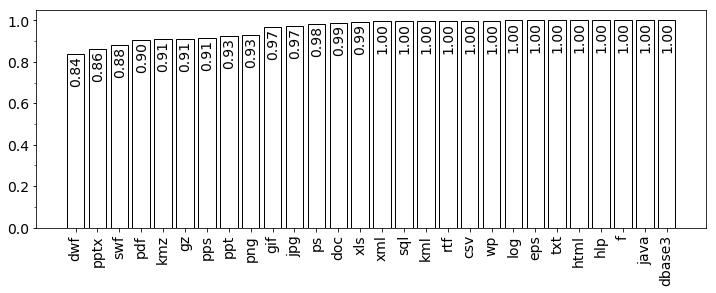

In [42]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data4['cat'], data4['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data4.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [43]:
data4.mean()

not_random         0.964259
random             0.988286
true_not_random    0.963227
dtype: float64

In [44]:
1-np.sum(data4['true_not_random'])/28

0.03677290167169722

In [45]:
1-(np.sum(data4['true_not_random'])+(1-0.62))/28

0.023201473100268655